## 1. Import MNIST Images

In [55]:
# 导入PyTorch库用于深度学习
import torch
import torch.nn as nn  # nn模块包含了构建神经网络所需的所有组件
import torch.nn.functional as F  # F提供了一些常用的激活函数和损失函数
from torch.utils.data import DataLoader  # DataLoader用于包装数据集，便于批处理和迭代
from torchvision import datasets, transforms  # datasets用于加载数据集，transforms用于数据预处理
from torchvision.utils import make_grid  # make_grid用于将多张图像拼接在一起，便于显示

# 导入其他科学计算和数据处理的库
import numpy as np  # NumPy用于高效的多维数组操作
import pandas as pd  # Pandas提供了强大的数据结构和数据分析工具
from sklearn.metrics import confusion_matrix  # confusion_matrix用于计算分类的混淆矩阵
import matplotlib.pyplot as plt  # Matplotlib是Python的绘图库，用于绘制图表和图像
%matplotlib inline  
# %matplotlib inline 是Jupyter Notebook的魔法命令，用于在Notebook中直接显示matplotlib生成的图像


In [56]:
# convert MNIST Image Files into a Tensor of 4-dimensions(# of images, height, width, colors)
transform = transforms.ToTensor() # 将 [0, 255] 范围内的 PIL 图像或 numpy.ndarray (H x W x C) 转换为形状 (C x H x W) 的 torch.FloatTensor

In [57]:
# train data
train_data = datasets.MNIST(root= 'dateset/cnn_data', train= True, download= True, transform= transform)

In [58]:
# test data
test_data = datasets.MNIST(root= 'dataset/cnn_data', train= False, download= True, transform= transform)

In [59]:
test_data


Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset/cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 2.Convolutional and Pooling Layers

In [60]:
# create a small batch size for images --- let's say 10
train_loader = DataLoader(train_data, batch_size= 10, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 10, shuffle= False)

In [61]:
#define our cnn model
#describe convolutional layer and what it is doing (2 convotional layers)
# this is just an example in the next vedio we will build out the actual model
conv1 = nn.Conv2d(in_channels=1, out_channels= 6, kernel_size= 3, stride= 1)
conv2 = nn.Conv2d(in_channels=6, out_channels= 16, kernel_size= 3, stride= 1)

In [62]:
# grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [63]:
X_Train.shape

torch.Size([1, 28, 28])

In [64]:
x = X_Train.view(1,1,28,28)

In [65]:
# perform our first convolution
x = F.relu(conv1(x)) #rectified linear unit for our activation function

In [66]:
# 1singel image, 6 is the filters we asked for , 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [67]:
# pass thru the pooling layer
x = F.max_pool2d(x, kernel_size= 2, stride= 2)

In [68]:
x.shape # 26/2

torch.Size([1, 6, 13, 13])

In [69]:
# do our second convolutional layer
x = F.relu(conv2(x))

In [70]:
#again we did not set padding so we lose 2 pixels around the outside of the image
x.shape

torch.Size([1, 16, 11, 11])

In [71]:
# pooling layer
x = F.max_pool2d(x, kernel_size= 2, stride= 2)


In [72]:
x.shape # 11 / 2 = 5.5 but we have to round down,because we can not invent data to round up

torch.Size([1, 16, 5, 5])

In [73]:
((28 - 2)/2 -2) /2

5.5

## 3.Convolutional Neural Network Model

In [74]:
# Model class 
class ConvolutonalNetaaaWork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 6, kernel_size= 3, stride= 1)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels= 16, kernel_size= 3, stride= 1)
        # fully connect layer
        self.fc1 = nn.Linear(in_features= 5*5*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features= 84)
        self.fc3 = nn.Linear(in_features=84, out_features= 10)

        #must have a foward function that pushes all that through
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(input= X, kernel_size= 2, stride= 2)
        #second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(input= X, kernel_size= 2, stride= 2)
        # re-view to flatten it out
        X = X.view(-1, 16*5*5) #-1 so that we can vary the batch size

        #fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(input= X, dim= 1)

In [75]:
#create 
torch.manual_seed(41)
model = ConvolutonalNetaaaWork()
model

ConvolutonalNetaaaWork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [76]:
#loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(), lr= 0.001)

## 4.Train and Test CNN Model 

In [77]:
import time
start_time = time.time()
# create varibles to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop of epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0


    #Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1 # start out batches at 1
        y_pred = model(X_train) # get predicted values from the training set,Not flattened;
        loss = criterion(y_pred, y_train) #how off we are,compare the predicitons to correct answer to y_train
        
        predicted =  torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. indexed off the first point
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch
        trn_corr += batch_corr  # keep track as we go along in trainging
        
        #update out parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #print out some results
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss:{loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)



    # Test
    with torch.no_grad(): #No gradient so we don't update our weight and biases with this test
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted =  torch.max(y_val.data, 1)[1] # add up the number of correct predictions. indexed off the first point
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss:0.16236098110675812
Epoch: 0 Batch: 1200 Loss:0.16147294640541077
Epoch: 0 Batch: 1800 Loss:0.46548572182655334
Epoch: 0 Batch: 2400 Loss:0.14589160680770874
Epoch: 0 Batch: 3000 Loss:0.006830060388892889
Epoch: 0 Batch: 3600 Loss:0.4129134714603424
Epoch: 0 Batch: 4200 Loss:0.004275710787624121
Epoch: 0 Batch: 4800 Loss:0.002969620516523719
Epoch: 0 Batch: 5400 Loss:0.04636438935995102
Epoch: 0 Batch: 6000 Loss:0.000430782965850085
Epoch: 1 Batch: 600 Loss:0.002715964335948229
Epoch: 1 Batch: 1200 Loss:0.17854242026805878
Epoch: 1 Batch: 1800 Loss:0.0020668990910053253
Epoch: 1 Batch: 2400 Loss:0.0038429438136518
Epoch: 1 Batch: 3000 Loss:0.03475978597998619
Epoch: 1 Batch: 3600 Loss:0.2954908013343811
Epoch: 1 Batch: 4200 Loss:0.02363143488764763
Epoch: 1 Batch: 4800 Loss:0.00022474219440482557
Epoch: 1 Batch: 5400 Loss:0.0005058477981947362
Epoch: 1 Batch: 6000 Loss:0.29113149642944336
Epoch: 2 Batch: 600 Loss:0.11854789406061172
Epoch: 2 Batch: 1200 Loss:0.

## 5.Graph CNN Results 

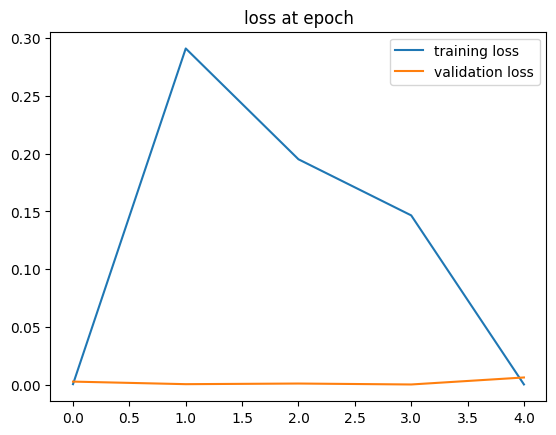

In [80]:
#graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label= "training loss")
plt.plot(test_losses, label="validation loss")
plt.title("loss at epoch")
plt.legend()

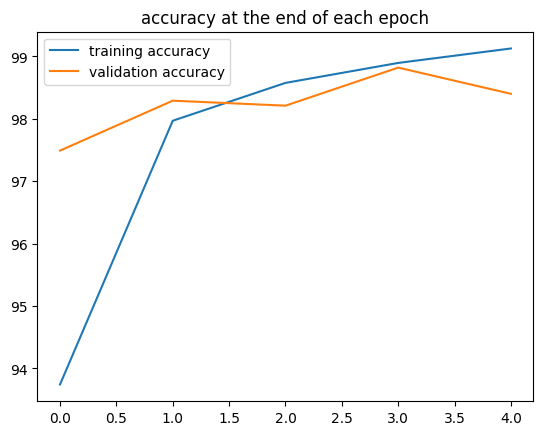

In [81]:
#graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "training accuracy")
plt.plot([t/100 for t in test_correct], label = "validation accuracy")
plt.title("accuracy at the end of each epoch")
plt.legend()

In [88]:
test_load_everything = DataLoader(test_data, batch_size= 10000, shuffle= False)

In [89]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()


In [90]:
# did for correct 
correct.item()/len(test_data) * 100

98.4

## Send New Image Thru The Model

In [91]:
# grab an image
test_data[4143] #tensor with an image in it ... at end ,it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [92]:
# grab just the data 
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [93]:
#reshape it 
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

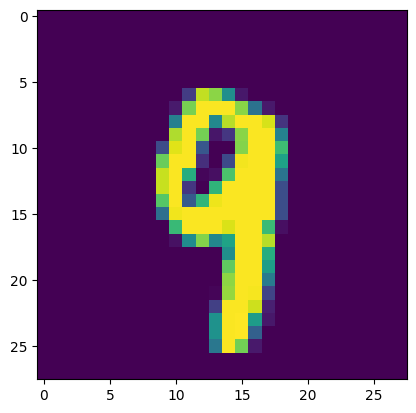

In [96]:
# show the image 

plt.imshow(test_data[4143][0].reshape(28,28))

In [97]:
# pass the image thru our model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1,1,28,28)) #batch size of 1,1 color channel, 28x28 image
    

In [98]:
# check the new prediction, get probabilities
new_prediction

tensor([[-2.3353e+01, -1.7943e+01, -2.6905e+01, -1.6105e+01, -9.3004e+00,
         -1.8874e+01, -3.4165e+01, -1.4187e+01, -1.3126e+01, -9.4171e-05]])

In [100]:
new_prediction.argmax()

tensor(9)